# "Full Metadata" Spreadsheet (working title)

See [ticket 576](https://app.zenhub.com/workspaces/dcp-ingest-product-development-5f71ca62a3cb47326bdc1b5c/issues/ebi-ait/dcp-ingest-central/576)

This is an initial attempt for enabling data consumers to explore the metadata of an HCA project with common simple tools with minimal coding such as Excel Pivot Tables.


In [127]:
input_dir= './data'
spreadsheet = f'{input_dir}/hca_template_20220518_minimal_donor_metadata_ontologies_CK.xlsx'
output_dir = './examples'
version = '0.5'

In [94]:
import ipywidgets as widgets
from IPython.display import display

report_entity_dropdown = widgets.Dropdown(
    options=['Sequence file', 'Image file', 'Analysis file'],
    value='Sequence file',
    description='Report Entity:',
    disabled=False,
)
display(report_entity_dropdown)

Dropdown(description='Report Entity:', options=('Sequence file', 'Image file', 'Analysis file'), value='Sequen…

In [131]:
report_entity = report_entity_dropdown.value

* TODO: skip unnecessary lines
* TODO: natural language column names vs variable names
* DONE: render graph
* DONE: analysis file linking
* DONE: handle CSV fields (separated by ||)
* TODO: analysis file -> imaged specimen <- image file
* TODO: same for analysis file -> cell suspension <- sequence file
* analysis file and image file are n:n relation

Define an Entity Relationship model (entity is a worksheet)

In [114]:
from dataclasses import dataclass

@dataclass
class SequencingProtocol:
    SEQUENCING_PROTOCOL_ID_Required: str
        
@dataclass
class LibraryPreparationProtocol:
    LIBRARY_PREPARATION_PROTOCOL_ID: str

@dataclass
class DissociationProtocol:
    DISSOCIATION_PROTOCOL_ID:str

@dataclass
class CollectionProtocol:
    COLLECTION_PROTOCOL_ID:str

@dataclass
class AnalysisProtocol:
    ANALYSIS_PROTOCOL_ID:str
        
@dataclass
class DonorOrganism:
    DONOR_ORGANISM_ID:str 
        
@dataclass
class SpecimenFromOrganism:
    SPECIMEN_FROM_ORGANISM_ID:str
    COLLECTION_PROTOCOL_ID:CollectionProtocol
    INPUT_DONOR_ORGANISM_ID:DonorOrganism
        
@dataclass
class EnrichmentProtocol:
    ENRICHMENT_PROTOCOL_ID:str
            
@dataclass
class CellSuspension:
    CELL_SUSPENSION_ID: str
    ENRICHMENT_PROTOCOL_ID:EnrichmentProtocol
    INPUT_SPECIMEN_FROM_ORGANISM_ID:SpecimenFromOrganism
    DISSOCIATION_PROTOCOL_ID:DissociationProtocol
    
@dataclass
class SequenceFile:
    SEQUENCING_PROTOCOL_ID_Required: SequencingProtocol
    LIBRARY_PREPARATION_PROTOCOL_ID_Required: LibraryPreparationProtocol
    INPUT_CELL_SUSPENSION_ID_Required: CellSuspension

        
@dataclass
class ImagingPreparationProtocol:
    IMAGING_PREPARATION_PROTOCOL_ID:str

        
@dataclass
class ImagedSpecimen:
    IMAGED_SPECIMEN_ID_Required:str
    INPUT_SPECIMEN_FROM_ORGANISM_ID_Required:SpecimenFromOrganism
    IMAGING_PREPARATION_PROTOCOL_ID_Required:ImagingPreparationProtocol


@dataclass
class AnalysisFile:
    ANALYSIS_PROTOCOL_ID_Required: AnalysisProtocol
    IMAGED_SPECIMEN_ID_Required:ImagedSpecimen
    CELL_SUSPENSION_ID_Required:CellSuspension
    LIBRARY_PREPARATION_PROTOCOL_ID_Required:LibraryPreparationProtocol
    SEQUENCING_PROTOCOL_ID_Required:SequencingProtocol

        
@dataclass
class ImagingProtocol:
    IMAGING_PROTOCOL_ID:str

        
@dataclass
class ImageFile:
    INPUT_IMAGED_SPECIMEN_ID:ImagedSpecimen
    IMAGING_PROTOCOL_ID:ImagingProtocol


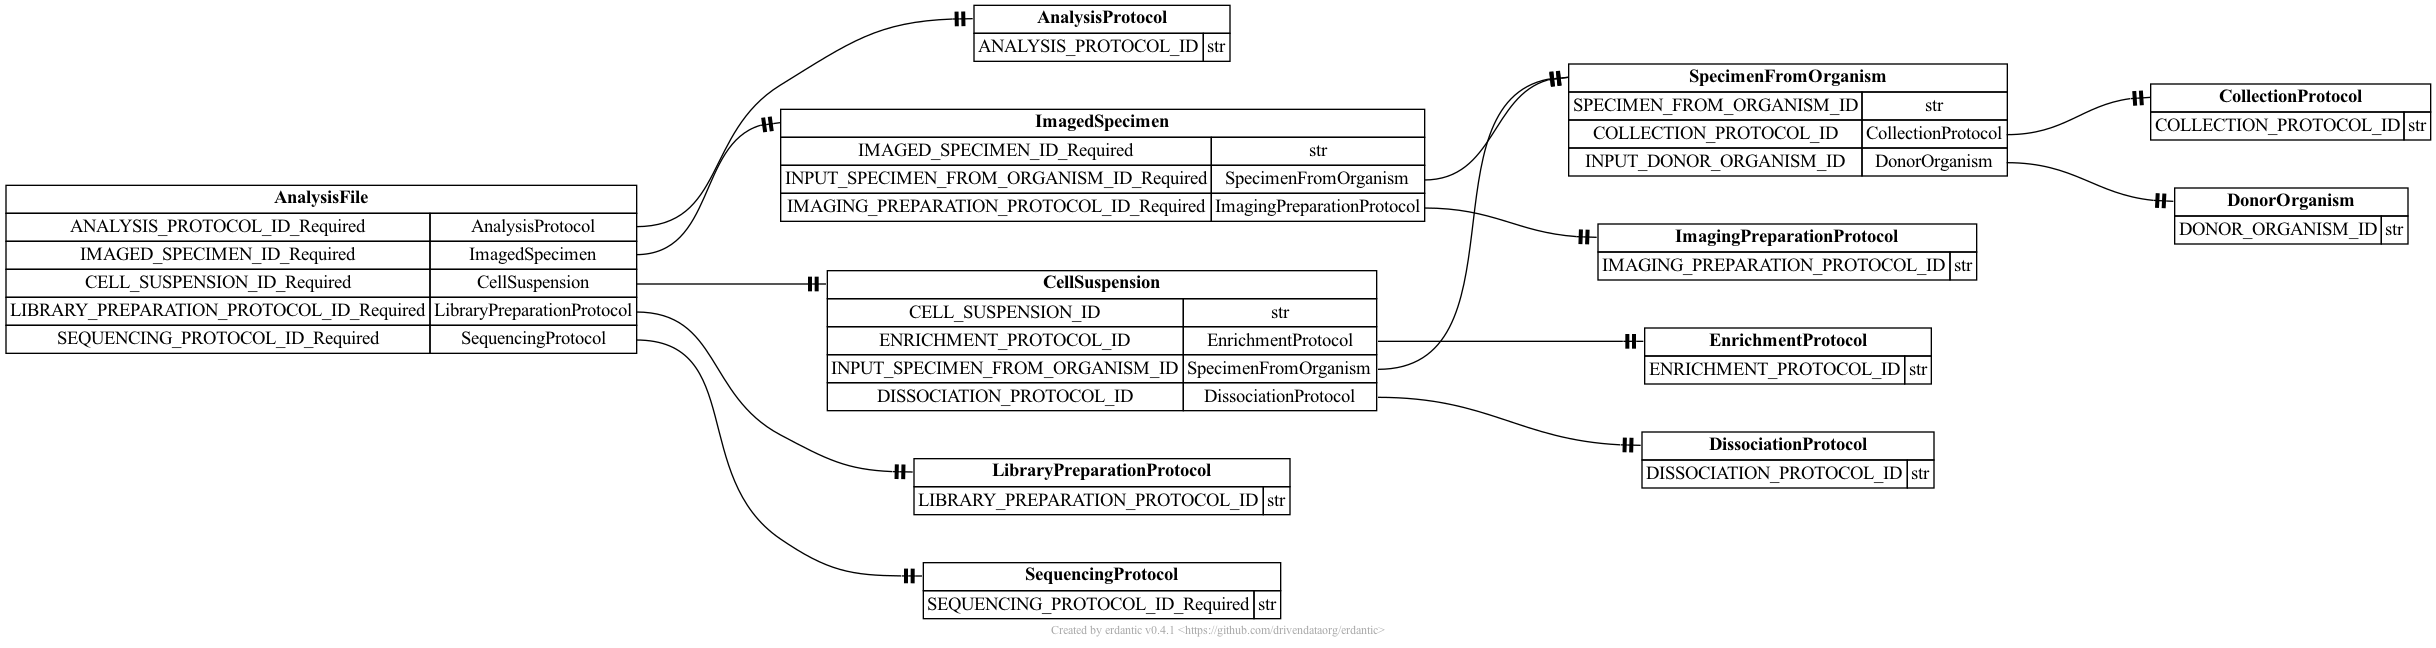

In [115]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import erdantic as erd
diagram = erd.create(AnalysisFile)
diagram

In [132]:
@dataclass
class Link:
    source:str
    target:str
    source_field:str
    target_field:str = None
    join_type:str = 'inner'
    
        
    def __post_init__(self):
        if self.target_field is None:
            self.target_field = self.source_field
        else:
            print(f'{self.source}->{self.target} using fields {self.source_field}->{self.target_field}')
        
# TODO: links list is assumed to be topologically sorted, in the future - sort
links = [
    Link('Image file', 'Imaged specimen', 'INPUT IMAGED SPECIMEN ID (Required)', 'IMAGED SPECIMEN ID (Required)'),
    Link('Image file', 'Imaging protocol', 'IMAGING PROTOCOL ID (Required)'),
    Link('Imaged specimen', 'Specimen from organism', 'INPUT SPECIMEN FROM ORGANISM ID (Required)', 'SPECIMEN FROM ORGANISM ID (Required)'),
    Link('Imaged specimen', 'Imaging preparation protocol', 'IMAGING PREPARATION PROTOCOL ID (Required)'),

#     Link('Sequence file', 'Sequencing protocol', 'SEQUENCING PROTOCOL ID (Required)'),
#     Link('Sequence file','Library preparation protocol', 'LIBRARY PREPARATION PROTOCOL ID (Required)'),
#    Link('Sequence file', 'Cell suspension', 'INPUT CELL SUSPENSION ID (Required)','CELL SUSPENSION ID (Required)'),

#     Link('Analysis file', 'Analysis protocol', 'ANALYSIS PROTOCOL ID (Required)', 'ANALYSIS PROTOCOL ID'),
#     Link('Analysis file', 'Cell suspension', 'CELL SUSPENSION ID (Required)'),
#     Link('Analysis file', 'Library preparation protocol', 'LIBRARY PREPARATION PROTOCOL ID (Required)'),
#     Link('Analysis file', 'Sequencing protocol', 'SEQUENCING PROTOCOL ID (Required)'),
    
#     Link('Cell suspension', 'Enrichment protocol','ENRICHMENT PROTOCOL ID (Required)'),
#     Link('Cell suspension', 'Specimen from organism','INPUT SPECIMEN FROM ORGANISM ID (Required)','SPECIMEN FROM ORGANISM ID (Required)'),
#     Link('Cell suspension', 'Dissociation protocol','DISSOCIATION PROTOCOL ID (Required)'),

    Link('Specimen from organism', 'Collection protocol', 'COLLECTION PROTOCOL ID (Required)'),
    Link('Specimen from organism', 'Donor organism','INPUT DONOR ORGANISM ID (Required)','DONOR ORGANISM ID (Required)'),

    
#     Link('Analysis file', 'Imaged specimen', 'IMAGED SPECIMEN ID (Required)'),    
#     Link('Imaged specimen', 'Analysis file', 'IMAGED SPECIMEN ID (Required)', join_type='left')
    
]



Image file->Imaged specimen using fields INPUT IMAGED SPECIMEN ID (Required)->IMAGED SPECIMEN ID (Required)
Imaged specimen->Specimen from organism using fields INPUT SPECIMEN FROM ORGANISM ID (Required)->SPECIMEN FROM ORGANISM ID (Required)
Specimen from organism->Donor organism using fields INPUT DONOR ORGANISM ID (Required)->DONOR ORGANISM ID (Required)


{('Image file',
  'Imaged specimen'): Text(0.28791193835555523, 0.30896585174958263, 'INPUT IMAGED SPECIMEN ID (Required)\n->IMAGED SPECIMEN ID (Required)'),
 ('Image file',
  'Imaging protocol'): Text(0.7790802037596868, 0.5639737234502864, 'IMAGING PROTOCOL ID (Required)\n->IMAGING PROTOCOL ID (Required)'),
 ('Imaged specimen',
  'Specimen from organism'): Text(-0.14626009058258385, -0.11539642810556607, 'INPUT SPECIMEN FROM ORGANISM ID (Required)\n->SPECIMEN FROM ORGANISM ID (Required)'),
 ('Imaged specimen',
  'Imaging preparation protocol'): Text(-0.11785401231308013, 0.3810928139212034, 'IMAGING PREPARATION PROTOCOL ID (Required)\n->IMAGING PREPARATION PROTOCOL ID (Required)'),
 ('Specimen from organism',
  'Collection protocol'): Text(-0.5491824529233778, -0.49343252957717965, 'COLLECTION PROTOCOL ID (Required)\n->COLLECTION PROTOCOL ID (Required)'),
 ('Specimen from organism',
  'Donor organism'): Text(-0.2671355637016813, -0.652774709001671, 'INPUT DONOR ORGANISM ID (Required)

<Figure size 432x288 with 0 Axes>

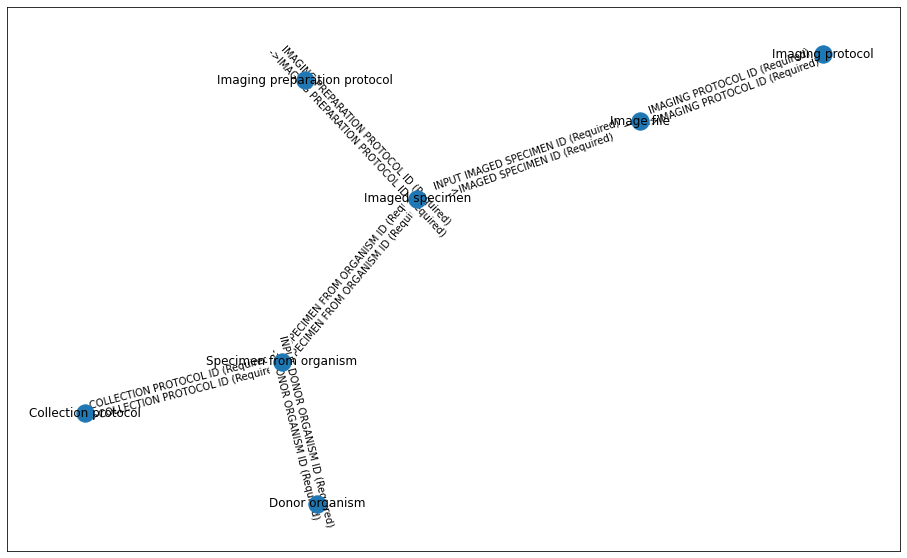

In [133]:
import networkx as nx
import matplotlib.pyplot as plt
from functools import partial


%matplotlib inline


def add_link_to_graph(graph :nx.Graph, link :Link):
    map(graph.add_node, filter(lambda node:node not in graph.nodes, [link.source, link.target] ))
    graph.add_edge(link.source, link.target, keys=f'{link.source_field}\n->{link.target_field}')

G = nx.Graph()
x =list(map(partial(add_link_to_graph, G), links))

fig = plt.figure()
plt.figure(figsize=(16, 10))

labels = nx.get_edge_attributes(G, 'keys')
pos = nx.spring_layout(G)          
nx.draw_networkx(G, pos, arrowstyle="->",)
nx.draw_networkx_edge_labels(G, pos, labels, font_size=10)


In [134]:
import pandas as pd
sep='\|\|'
def explode_csv_col(df :pd.DataFrame, column :str, sep=',') -> pd.DataFrame:
    cols={}
    cols[column] = df[column].str.split(sep)
    return df.assign(**cols).explode(column)

def format_column_name(column_name, namespace):
    return f'{namespace}_{column_name}'

def prefix_columns(df, prefix):
    return df.rename(columns=lambda c:format_column_name(namespace=prefix,column_name=c))

first_data_line=4
def remove_field_desc_lines(df:pd.DataFrame) -> pd.DataFrame:
    return df[first_data_line:]

In [135]:
from datetime import datetime
now = lambda : datetime.now().strftime('%H%M%S.%f')

import os
def join_worksheet(worksheet:pd.DataFrame, link:Link, spreadsheet:str) -> pd.DataFrame:
    print(f'joining [{link.source}] to [{link.target}]')
    print(f'fields [{link.source_field}] and [{link.target_field}]')
    try:
        source_field = format_column_name(column_name=link.source_field, namespace=link.source)
        target_field = format_column_name(column_name=link.target_field, namespace=link.target)
        worksheet = explode_csv_col(df=worksheet, column=source_field, sep=sep)
 
        spreadsheet_obj = pd.ExcelFile(spreadsheet)
        if link.target not in spreadsheet_obj.sheet_names:
            raise ValueError(f'spreadsheet does not contain {link.target} sheet. Possible names {sorted(spreadsheet_obj.sheet_names)}')
        target = spreadsheet_obj.parse(link.target)

        target = pd.read_excel(spreadsheet, link.target)
        target = remove_field_desc_lines(target)
        target = prefix_columns(target, prefix=link.target)

        target = explode_csv_col(target, column=target_field, sep=sep)

        result = worksheet.merge(target, 
                                 how=link.join_type, 
                                 left_on=source_field, 
                                 right_on=target_field)
        if len(result.index) == 0:
            raise RuntimeError('problem joining [{link.source}] to [{link.target}] using fields [{source_field}] and [{target_field}]: join resulted in zero rows')
        
    except KeyError as e:
        err_msg = f'problem joining [{link.source}] to [{link.target}] using fields [{source_field}] and [{target_field}]: {e}'
        raise RuntimeError(err_msg) from e
    return result

In [136]:
import pandas as pd
from collections import namedtuple
from functools import partial, reduce

def flatten_spreadsheet(spreadsheet, report_entity):
    spreadsheet_obj = pd.ExcelFile(spreadsheet)
    if report_entity not in spreadsheet_obj.sheet_names:
        raise ValueError(f'spreadsheet does not contain {report_entity} sheet')
    report_sheet = spreadsheet_obj.parse(report_entity)
    report_sheet = prefix_columns(report_sheet, prefix=report_entity)
    report_sheet = remove_field_desc_lines(report_sheet)
    flattened = reduce(partial(join_worksheet, spreadsheet=spreadsheet), 
                       links,
                       report_sheet)
    return flattened
flattened = flatten_spreadsheet(spreadsheet, report_entity)

joining [Image file] to [Imaged specimen]
fields [INPUT IMAGED SPECIMEN ID (Required)] and [IMAGED SPECIMEN ID (Required)]
joining [Image file] to [Imaging protocol]
fields [IMAGING PROTOCOL ID (Required)] and [IMAGING PROTOCOL ID (Required)]
joining [Imaged specimen] to [Specimen from organism]
fields [INPUT SPECIMEN FROM ORGANISM ID (Required)] and [SPECIMEN FROM ORGANISM ID (Required)]
joining [Imaged specimen] to [Imaging preparation protocol]
fields [IMAGING PREPARATION PROTOCOL ID (Required)] and [IMAGING PREPARATION PROTOCOL ID (Required)]
joining [Specimen from organism] to [Collection protocol]
fields [COLLECTION PROTOCOL ID (Required)] and [COLLECTION PROTOCOL ID (Required)]
joining [Specimen from organism] to [Donor organism]
fields [INPUT DONOR ORGANISM ID (Required)] and [DONOR ORGANISM ID (Required)]


In [137]:
from os.path import basename, splitext
report_entity_clean = report_entity.replace(" ","-")
flattened_filename = f'{output_dir}/{splitext(basename(spreadsheet))[0]}_denormalised_{report_entity_clean}_v{version}.xlsx'
flattened.to_excel(flattened_filename)

In [138]:
import openpyxl
import getpass
fh = openpyxl.load_workbook(flattened_filename)

obj = fh.properties   
project_info = pd.read_excel(spreadsheet, 'Project')
data_row_idx = 4
project_label = project_info['PROJECT LABEL (Required)'][data_row_idx]

fh.properties.title = f'denormalised hca metadata for project {project_label} showing {report_entity}'
fh.properties.version = version
fh.properties.keywords = f'flattened,hca,metadata,{project_label},{report_entity_clean}'
fh.properties.creator = getpass.getuser( )
fh.properties.lastModifiedBy = getpass.getuser( )
fh.properties.created=datetime.now()
fh.properties.modified=datetime.now()


fh.save(flattened_filename)

In [139]:
field_list = ['_FILE NAME (Required)', '_FILE FORMAT (Required)']
field_list = [report_entity + f for f in field_list]
flattened[field_list]

,Image file_FILE NAME (Required),Image file_FILE FORMAT (Required)
0,spatial_10X0017_spatial.zip,zip
1,spatial_10X0020_spatial.zip,zip
2,spatial_10X0026_spatial.zip,zip
3,spatial_10X0018_spatial.zip,zip
4,spatial_10X0025_spatial.zip,zip
5,spatial_ACH0028_spatial.zip,zip
6,spatial_10X001_spatial.zip,zip
7,spatial_10X0027_spatial.zip,zip
8,spatial_10X009_spatial.zip,zip
9,spatial_ACH0010_spatial.zip,zip


0